In [ ]:
import cv2
from paddleocr import PaddleOCR
from matplotlib import pyplot as plt
import constants as c
#from process_image import *
from process_data import *
from datetime import datetime
import time
import pandas as pd
import numpy as np
from collections import Counter


In [ ]:
ocr = PaddleOCR(lang='en',  use_angle_cls=False)

In [8]:
def processing_image(image, posicao):

    cropped_image = image[posicao[0]:posicao[1], posicao[2]:posicao[3]]
    cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
    cropped_image = cv2.GaussianBlur(cropped_image,(3,3),0)
    # Invertendo caso a cor mais comum seja menor que 125 (caso box vermelho)
    cropped_image = cv2.bitwise_not(cropped_image)
    M = np.ones(cropped_image.shape, dtype="uint8") * 50
    #cropped_image = cv2.subtract(cropped_image, M)
    data = Counter(cropped_image.ravel())
    aux = 255/(max(data) - min(data))
    cropped_image = cropped_image - min(data)
    cropped_image = cv2.multiply(cropped_image,aux)
    #Adicionando borda
    cropped_image = cv2.copyMakeBorder(cropped_image, 100, 100, 70, 70, cv2.BORDER_CONSTANT, None, value=[255, 255, 255])
    
    return cropped_image


In [ ]:
directory = '../frames/T27/'
ini = 0
fim = 9709
n = 0
for i in range(ini,fim):
    print(i)
    path = directory + 't27/' +  str(i) + '.png'
    image = cv2.imread(path)
    for key, param in c.inst_motor_T27.items():
        inst = param
        final_image = processing_image(image, inst)
        path = directory + key +'/'+ key +'_' + str(i) +'.png'
        
        cv2.imwrite(path, final_image)

In [ ]:
directory = '../frames/T27/'
result = []
df2_result = []
df3_result = []
ini = 0
quant = 1921



for i in range(ini,quant):
    
    
    row_result = []
    df2_row = []
    for key, param in c.inst_motor_T27.items():
        path = directory + key +'/'+ key +'_' + str(i) +'.png'
        image = cv2.imread(path)
        number = ocr.ocr(image, cls=False)

        if not number:
            row_result.append(None)
            df2_row.append(None)
        else:
            
            if number[0][1][1] < 0.8:
                df2_row.append(key + "_"+ str(i) + ".png " + str(number[0][1]))
                row_result.append(None)
            else:
                text = process_data(number[0][1][0], key)
                row_result.append(text)
                df2_row.append(None)


    result.append(row_result)
    df2_result.append(df2_row)
    print("\n\n#########################\t", str(i),"\t#########################\n\n" )
    

df = pd.DataFrame(result, columns=c.columns_t27)

path = 'csv/T27/T27_' + datetime.today().strftime('%m%d_%H%M') + '.csv'
df.to_csv(path, index= False)

df2 = pd.DataFrame(df2_result,  columns=c.columns_t27)
                           
path2 = 'csv/T27/T27_conf_' + datetime.today().strftime('%m%d_%H%M') + '.csv'
df2.to_csv(path2, index= False)

In [36]:
path = 'dados_sim/T27.csv'
df = pd.read_csv(path)
df = df.drop(columns=["Frame","Unnamed: 10"])
df = df.round(1)
df = df[1:]
df

,NG,NH,T5,TRQ,OIL_PRESS,OIL_TEMP,FF,SPEED,ALT
1,97.7,115.2,690.7,1004.4,84.8,60.5,275.6,107.5,11985.3
2,96.5,116.5,682.8,954.9,84.7,60.5,273.2,107.4,11990.3
3,95.7,118.4,677.8,922.3,84.7,60.5,270.9,107.3,11993.4
4,95.0,119.1,673.2,888.2,84.7,60.5,268.9,107.2,11996.2
5,94.3,118.5,668.8,857.1,84.6,60.5,266.1,107.0,11998.8
...,...,...,...,...,...,...,...,...,...
15416,84.7,90.4,605.7,567.9,81.5,57.6,257.5,101.4,7421.6
15417,84.7,90.4,605.7,568.0,81.5,57.6,257.5,101.6,7419.5
15418,84.7,90.4,605.7,568.0,81.5,57.6,257.5,101.8,7417.5
15419,84.7,90.4,605.7,568.1,81.5,57.6,257.5,102.0,7415.4


In [38]:
def drop_outliers(df):
    df1 = pd.DataFrame()
    for column in df:
        value = df[column].tolist()
        
        limit = c.scala_motor_T27[column]
        for i in range(1,len(value)):
            if value[i]!= None and value[i-1]!= None:
                if abs(value[i] - value[i-1]) > 5*limit:
                    #print(column, i)
                    value[i] = None
                    #print(i)
        
        df1[column] = value
    return df1

In [39]:
path = 'csv/T27/T27_1027_0003.csv'
res = pd.read_csv(path)
res = res[107:]
res.describe()

,NG_1,NG_2,NH_1,NH_2,T5_1,T5_2,TRQ_1,TRQ_2,OIL_PRESS_1,OIL_PRESS_2,OIL_TEMP_1,FF_1,FF_2
count,9600.000000,9600.000000,9600.000000,9600.000000,9599.000000,9600.000000,9600.000000,9600.000000,9411.000000,7535.000000,9599.000000,9600.000000,9205.000000
mean,84.556583,84.564917,90.671927,90.672479,604.931034,604.932708,693.965937,693.965937,81.361173,68.167100,53.344723,250.778333,233.251179
std,10.388443,10.353517,7.560025,7.560699,67.515761,67.512444,485.794396,485.794396,3.511653,29.716582,9.957674,49.024985,81.500111
min,1.100000,63.400000,23.600000,23.600000,467.000000,467.000000,53.000000,53.000000,-85.000000,0.500000,34.000000,160.000000,0.300000
25%,82.900000,82.900000,89.900000,89.900000,594.000000,594.000000,451.000000,451.000000,81.000000,80.800000,48.000000,222.000000,222.300000
50%,84.700000,84.700000,90.000000,90.000000,606.000000,606.000000,565.000000,565.000000,81.000000,81.500000,55.000000,240.000000,239.000000
75%,90.900000,90.900000,90.200000,90.200000,646.000000,646.000000,1000.000000,1000.000000,83.000000,83.300000,60.000000,303.000000,303.500000
max,100.200000,100.200000,119.100000,119.100000,707.000000,707.000000,1628.000000,1628.000000,85.000000,85.000000,70.000000,337.000000,336.900000


In [40]:
res = drop_outliers(res)
res.describe()

,NG_1,NG_2,NH_1,NH_2,T5_1,T5_2,TRQ_1,TRQ_2,OIL_PRESS_1,OIL_PRESS_2,OIL_TEMP_1,FF_1,FF_2
count,9545.000000,9546.000000,9353.000000,9357.000000,9573.000000,9574.000000,9274.000000,9274.000000,9409.000000,7445.000000,9599.000000,9594.00000,8796.000000
mean,84.590718,84.590352,90.914530,90.918104,604.951635,604.953311,694.448458,694.448458,81.396429,68.435809,53.344723,250.77142,234.618884
std,10.362094,10.361613,6.762618,6.763430,67.587151,67.583820,489.012710,489.012710,2.546534,29.544311,9.957674,49.03447,80.624810
min,63.400000,63.400000,23.600000,23.600000,467.000000,467.000000,53.000000,53.000000,76.000000,0.500000,34.000000,160.00000,0.300000
25%,82.900000,82.900000,89.900000,89.900000,594.000000,594.000000,452.000000,452.000000,81.000000,80.800000,48.000000,222.00000,222.500000
50%,84.700000,84.700000,90.000000,90.000000,606.000000,606.000000,565.000000,565.000000,81.000000,81.600000,55.000000,240.00000,240.000000
75%,90.900000,90.900000,90.100000,90.100000,646.000000,646.000000,1000.000000,1000.000000,83.000000,83.400000,60.000000,303.00000,303.700000
max,100.200000,100.200000,119.100000,119.100000,707.000000,707.000000,1628.000000,1628.000000,85.000000,85.000000,70.000000,337.00000,336.900000


In [26]:
path = 'csv/T27/T27_1027_0003.csv'
res = pd.read_csv(path)
res = res[107:]
res = drop_outliers(res)
res

,NG_1,NG_2,NH_1,NH_2,T5_1,T5_2,TRQ_1,TRQ_2,OIL_PRESS_1,OIL_PRESS_2,OIL_TEMP_1,FF_1,FF_2
107,96.5,96.5,116.5,116.5,683.0,683.0,955.0,955.0,85.0,84.7,60.0,273.0,273.2
108,95.7,95.7,118.4,118.4,678.0,678.0,922.0,922.0,85.0,84.7,60.0,271.0,210.9
109,95.0,95.0,119.1,119.1,673.0,673.0,888.0,888.0,85.0,84.7,61.0,269.0,268.9
110,95.0,95.0,119.1,119.1,673.0,673.0,888.0,888.0,85.0,84.7,61.0,269.0,268.9
111,95.0,95.0,119.1,119.1,673.0,673.0,888.0,888.0,85.0,84.7,61.0,269.0,268.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9702,84.7,84.7,90.1,90.1,606.0,606.0,566.0,566.0,82.0,81.5,58.0,257.0,256.9
9703,84.7,84.7,90.1,90.1,606.0,606.0,566.0,566.0,82.0,81.5,58.0,257.0,256.9
9704,84.7,84.7,90.1,90.1,606.0,606.0,566.0,566.0,82.0,81.5,58.0,257.0,256.9
9705,84.7,84.7,90.1,90.1,606.0,606.0,566.0,566.0,82.0,81.5,58.0,257.0,256.9


In [41]:
df_compare = pd.DataFrame()
df_compare['NG_Real'] = df['NG']
df_compare["NG_1"] = res["NG_1"]
df_compare['NH_Real'] = df['NH']
df_compare["NH_1"] = res["NH_1"]
df_compare['T5_Real'] = df['T5']
df_compare["T5_1"] = res["T5_1"]
df_compare['TRQ_Real'] = df['TRQ']
df_compare["TRQ_1"] = res["TRQ_1"]
df_compare['OIL_PRESS_Real'] = df['OIL_PRESS']
df_compare["OIL_PRESS_1"] = res["OIL_PRESS_1"]
df_compare['FF_Real'] = df['FF']
df_compare["FF_1"] = res["FF_1"]
df_compare['OIL_TEMP_Real'] = df['OIL_TEMP']
df_compare["OIL_TEMP_1"] = res["OIL_TEMP_1"]
df_compare

,NG_Real,NG_1,NH_Real,NH_1,T5_Real,T5_1,TRQ_Real,TRQ_1,OIL_PRESS_Real,OIL_PRESS_1,FF_Real,FF_1,OIL_TEMP_Real,OIL_TEMP_1
1,97.7,NaN,115.2,NaN,690.7,678.0,1004.4,NaN,84.8,85.0,275.6,271.0,60.5,60.0
2,96.5,95.0,116.5,119.1,682.8,673.0,954.9,888.0,84.7,85.0,273.2,269.0,60.5,61.0
3,95.7,95.0,118.4,119.1,677.8,673.0,922.3,888.0,84.7,85.0,270.9,269.0,60.5,61.0
4,95.0,95.0,119.1,119.1,673.2,673.0,888.2,888.0,84.7,85.0,268.9,269.0,60.5,61.0
5,94.3,95.0,118.5,119.1,668.8,673.0,857.1,888.0,84.6,85.0,266.1,269.0,60.5,61.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15416,84.7,NaN,90.4,NaN,605.7,NaN,567.9,NaN,81.5,NaN,257.5,NaN,57.6,NaN
15417,84.7,NaN,90.4,NaN,605.7,NaN,568.0,NaN,81.5,NaN,257.5,NaN,57.6,NaN
15418,84.7,NaN,90.4,NaN,605.7,NaN,568.0,NaN,81.5,NaN,257.5,NaN,57.6,NaN
15419,84.7,NaN,90.4,NaN,605.7,NaN,568.1,NaN,81.5,NaN,257.5,NaN,57.6,NaN


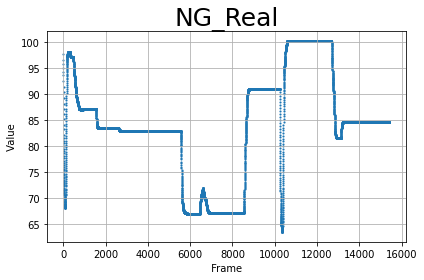

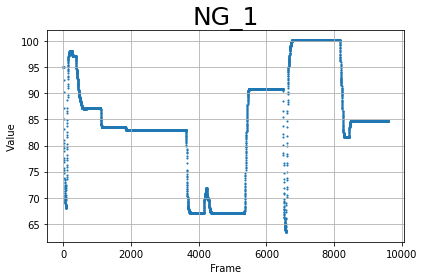

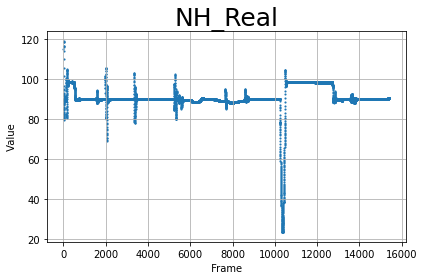

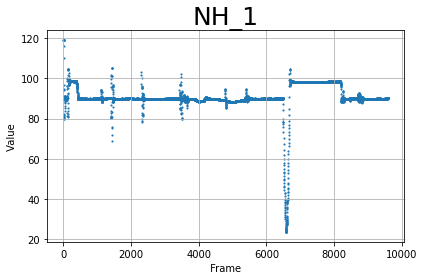

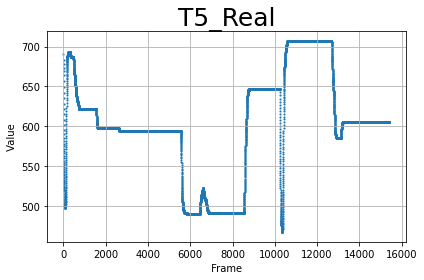

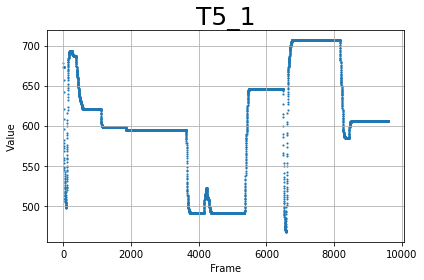

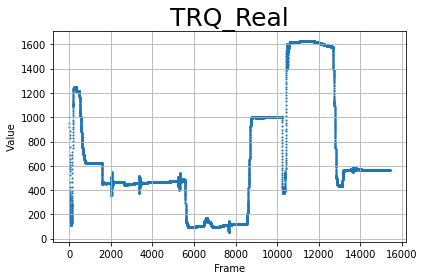

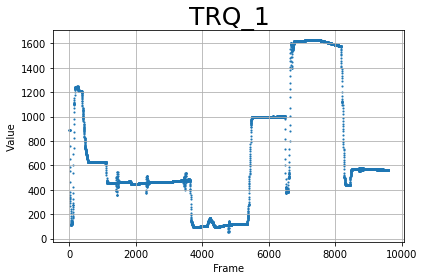

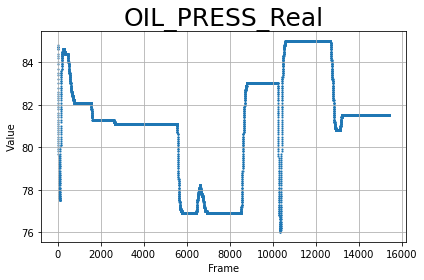

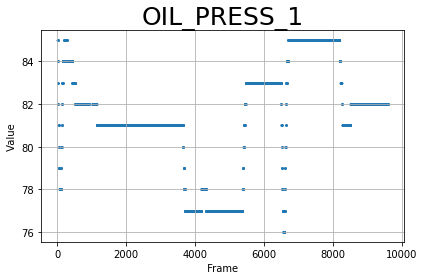

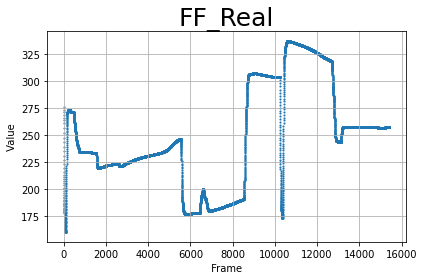

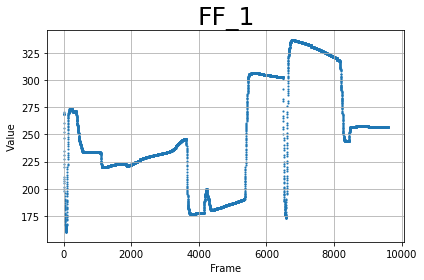

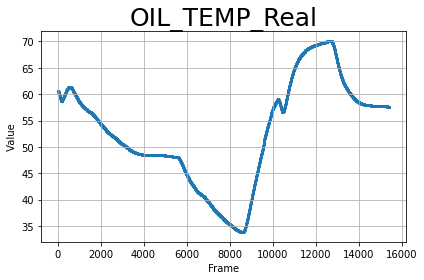

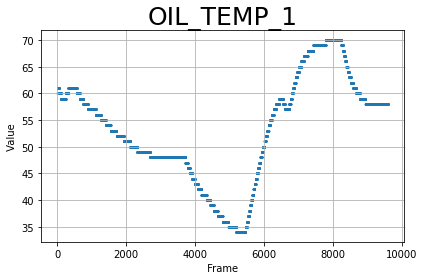

In [42]:
df = df_compare.copy()
for column in df:
  inst = str(column)
  
  fig, ax = plt.subplots()

  x = df.index.tolist()
  y = df[column].values.tolist()
  ax.scatter(x,y, marker=".", s =5)
  plt.grid ()
  title = column
  plt.title(title,fontsize=25)
  plt.xlabel ( ' Frame ')
  plt.ylabel ( ' Value ')
  plt.tight_layout ()
  plt.show()